# Group Genes For SSIT

In [2]:
import scanpy as sc
import scvi
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import os
import random


/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load in data

In [3]:
current_dir = os.getcwd()

parentfolder = os.path.pardir
file_path = os.path.join(parentfolder, 'Datasets/DUSP1/A1-2_sc_Bulk_GSE141834/GSE141834_scRNAseq_rawCounts.txt')

print(file_path)

../Datasets/DUSP1/A1-2_sc_Bulk_GSE141834/GSE141834_scRNAseq_rawCounts.txt


In [4]:
adata = sc.read_text(file_path).T

In [7]:
adata

AnnData object with n_obs × n_vars = 2400 × 32049

In [6]:
len(adata.X.sum(axis=0))

32049

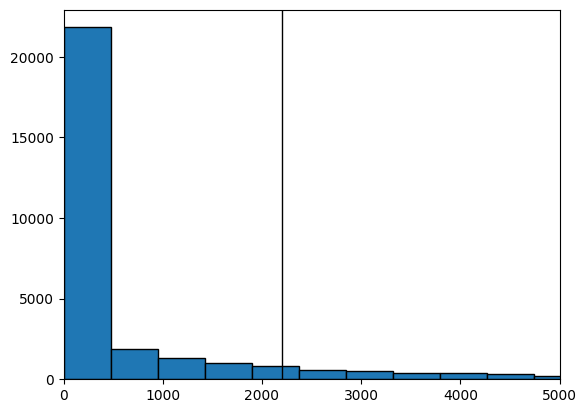

In [20]:
plt.axvline(x=adata.X.sum(axis=0).mean(), color='black', linestyle='-', linewidth=1)
plt.hist(adata.X.sum(axis=0), bins=1000, edgecolor='black')
plt.xlim(0,5000)
plt.show()


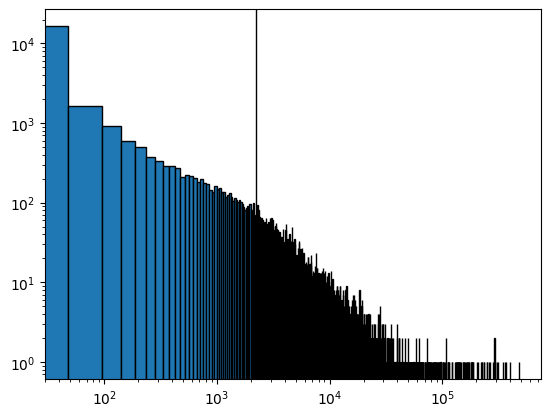

In [22]:
plt.axvline(x=adata.X.sum(axis=0).mean(), color='black', linestyle='-', linewidth=1)
plt.hist(adata.X.sum(axis=0), bins=10000, edgecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.show()


# Down Sample
<br> Doesn't matter 

In [5]:
print(adata.shape)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=10)
print(adata.shape)

(2400, 32049)
(2400, 19841)


# Seperate Timepoints & Treatments

In [6]:
adata.obs['Timepoint'] = [x.split('.')[1] for x in adata.obs_names]
adata.obs['Treatment'] = [x.split('.')[0] for x in adata.obs_names]

adata.obs['Timepoint'] = adata.obs['Timepoint']
adata.obs['Treatment'] = adata.obs['Treatment']

# Clean the data
I hope I dont have to

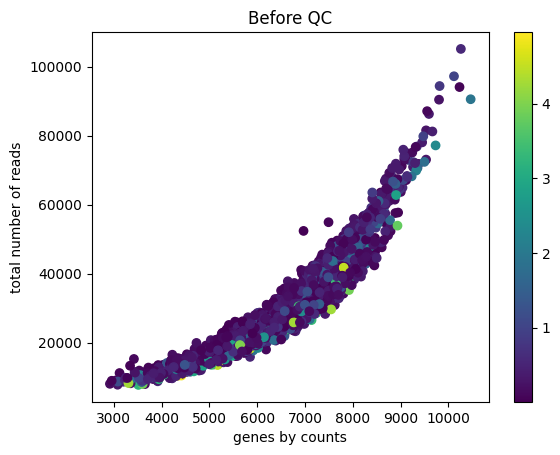

"upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)\nlower_lim = np.quantile(adata.obs.n_genes_by_counts.values, .02)\nprint(f'{lower_lim} to {upper_lim}')\nadata = adata[(adata.obs.n_genes_by_counts < upper_lim) & (adata.obs.n_genes_by_counts > lower_lim)]\nadata = adata[adata.obs.pct_counts_mt < 20]\n\nplt.scatter(adata.obs['n_genes_by_counts'], adata.obs['total_counts'], c=adata.obs['pct_counts_mt'])\nplt.xlabel('genes by counts')\nplt.ylabel('total number of reads')\nplt.title(adata.uns['Dataset_name'] + ' After QC')\nplt.colorbar()\nplt.show()"

In [7]:
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)
#sc.pl.violin(adata[i_d], ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

plt.scatter(adata.obs['n_genes_by_counts'], adata.obs['total_counts'], c=adata.obs['pct_counts_mt'])
plt.xlabel('genes by counts')
plt.ylabel('total number of reads')
plt.title("Before QC")
plt.colorbar()
plt.show()

"""upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
lower_lim = np.quantile(adata.obs.n_genes_by_counts.values, .02)
print(f'{lower_lim} to {upper_lim}')
adata = adata[(adata.obs.n_genes_by_counts < upper_lim) & (adata.obs.n_genes_by_counts > lower_lim)]
adata = adata[adata.obs.pct_counts_mt < 20]

plt.scatter(adata.obs['n_genes_by_counts'], adata.obs['total_counts'], c=adata.obs['pct_counts_mt'])
plt.xlabel('genes by counts')
plt.ylabel('total number of reads')
plt.title(adata.uns['Dataset_name'] + ' After QC')
plt.colorbar()
plt.show()"""

In [8]:
sc.pp.filter_genes(adata, min_cells = 100)

sc.pp.normalize_total(adata, target_sum=1e4)
adata.layers['counts'] = adata.X.copy()
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=5000)

adata.raw = adata

/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [9]:
#adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) # regresses out effect
sc.pp.scale(adata, max_value=10) # treats all genes the same

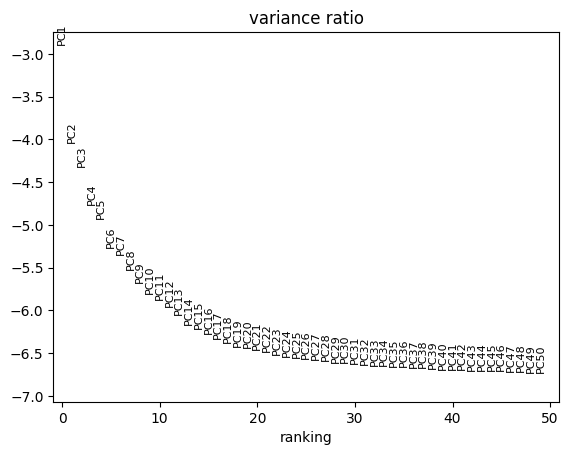

In [10]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


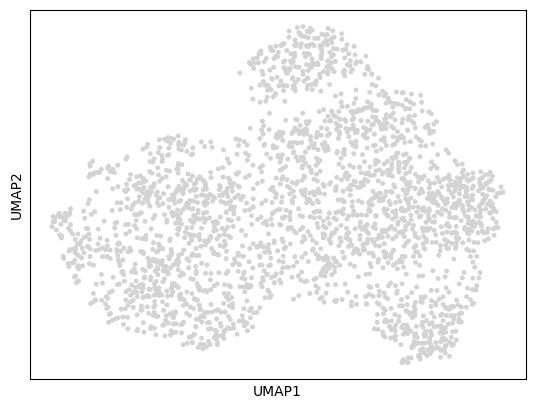

In [11]:
sc.pp.neighbors(adata, n_pcs = 30)
sc.tl.umap(adata)
sc.pl.umap(adata)

/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warn

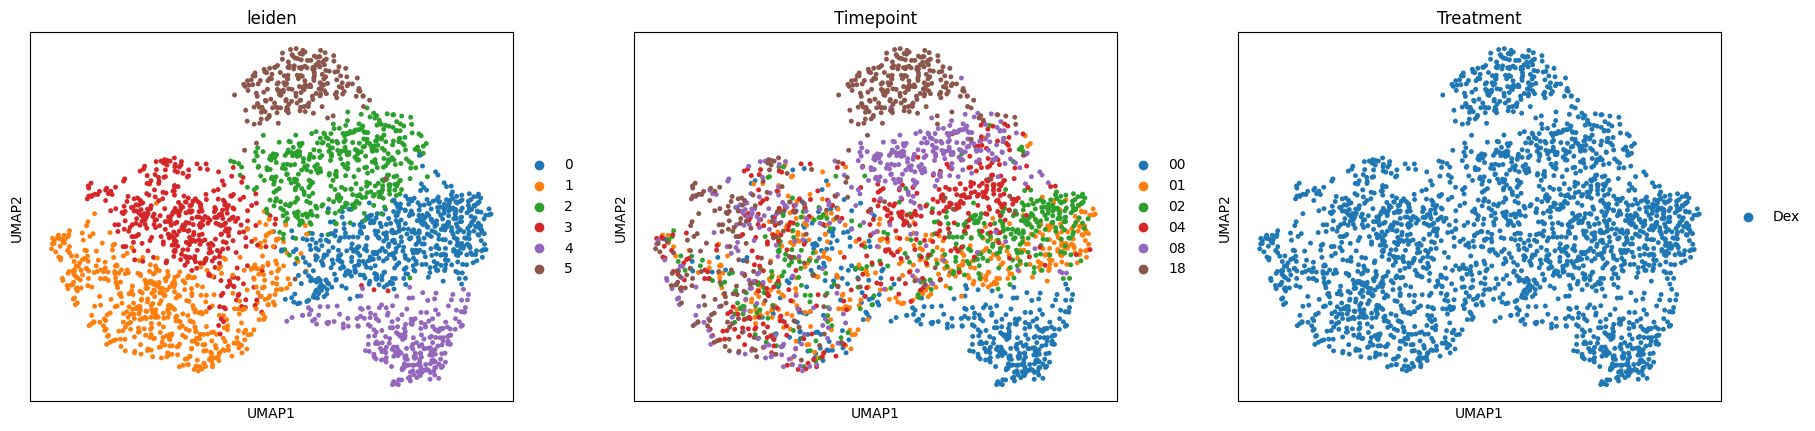

In [12]:
sc.tl.leiden(adata, resolution = 0.5)
sc.pl.umap(adata, color=['leiden', 'Timepoint', 'Treatment'])

In [13]:
'DUSP1' in adata.var_names

True

In [14]:
adata.write_h5ad('NormalizedData_Counts.h5ad')

In [15]:
sc.tl.rank_genes_groups(adata, 'Timepoint')

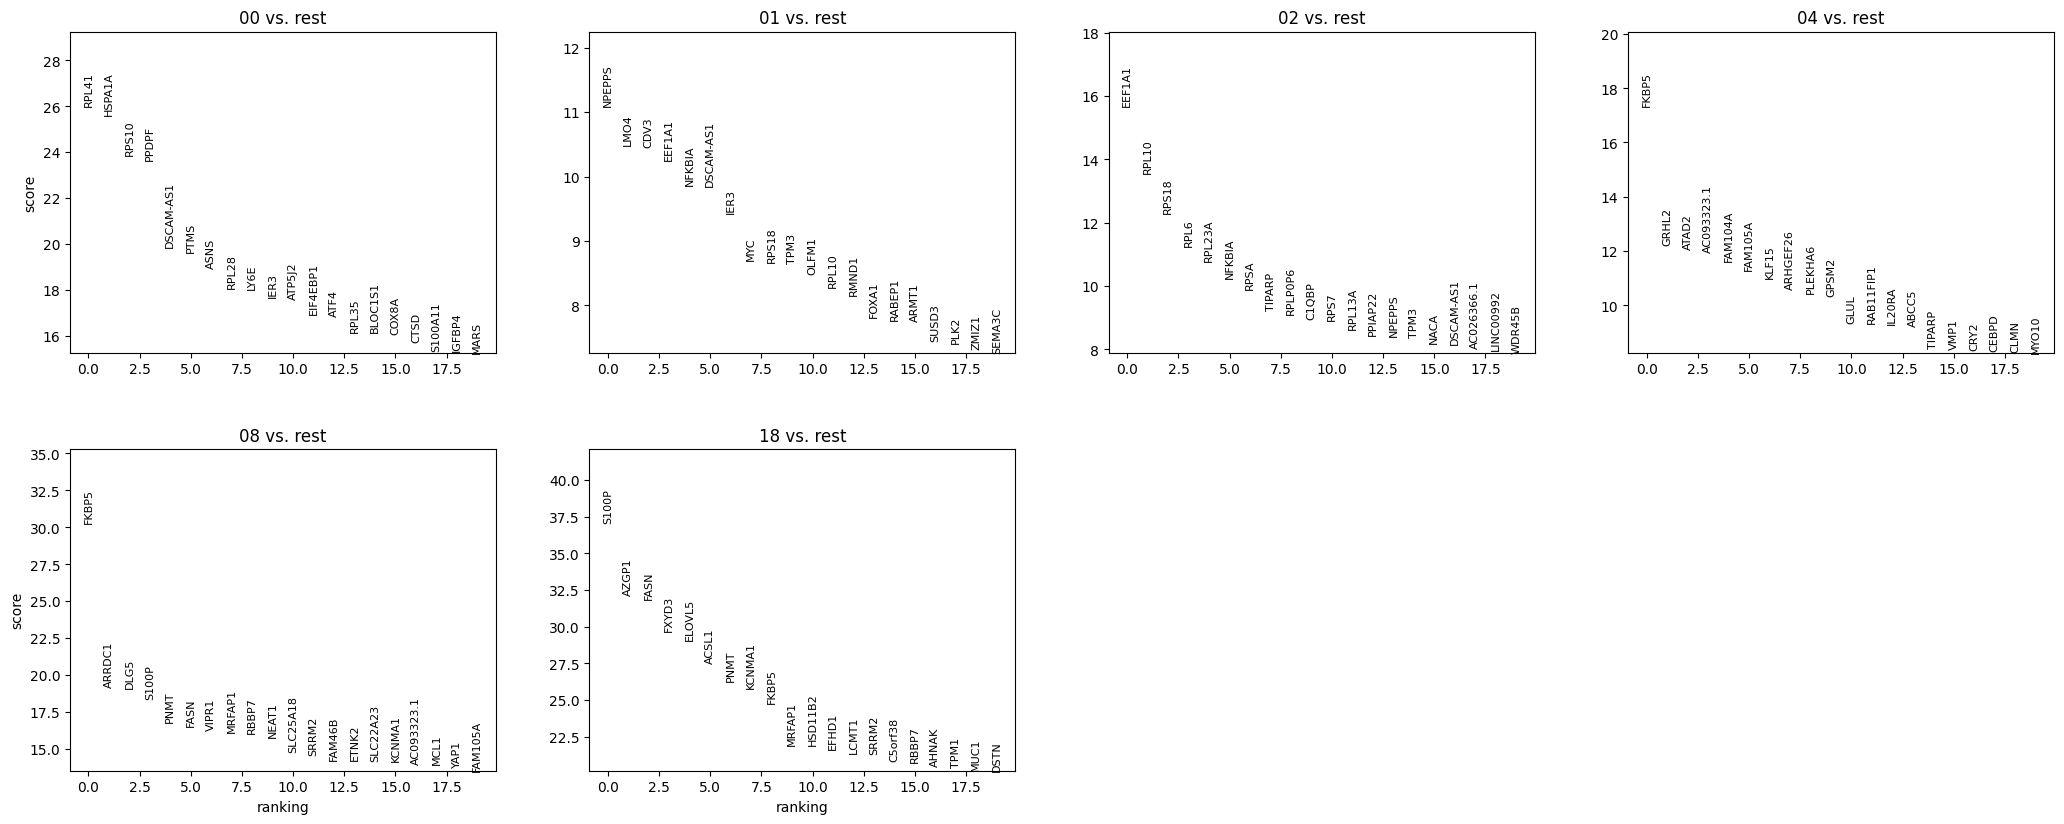

In [16]:
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [17]:
markers = sc.get.rank_genes_groups_df(adata, None)
markers

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,00,RPL41,26.021839,0.442783,3.292639e-100,2.223190e-97
1,00,HSPA1A,25.603756,1.538856,3.760577e-95,2.115951e-92
2,00,RPS10,23.874685,0.710182,3.817589e-89,1.909360e-86
3,00,PPDPF,23.648649,0.571174,2.163017e-87,9.736463e-85
4,00,DSCAM-AS1,19.852564,0.869926,1.208422e-69,3.626339e-67
...,...,...,...,...,...,...
81019,18,DSCAM-AS1,-15.308792,-0.912191,2.959028e-44,9.989678e-42
81020,18,SEMA3C,-16.074827,-1.094508,2.402639e-49,9.012565e-47
81021,18,LMO4,-18.235256,-1.236951,3.060578e-59,1.722085e-56
81022,18,LINC00992,-18.833908,-1.438323,6.920733e-65,4.450361e-62


In [18]:
markers[markers['names'].str.contains('DUSP1')]

,group,names,scores,logfoldchanges,pvals,pvals_adj
3401,00,DUSP13,1.100455,0.434036,2.716463e-01,4.260524e-01
3894,00,DUSP15,0.847950,0.301039,3.968424e-01,5.534401e-01
6322,00,DUSP10,-0.260126,-0.103316,7.948662e-01,8.718220e-01
7571,00,DUSP12,-0.789625,-0.063388,4.300831e-01,5.842312e-01
9200,00,DUSP16,-1.541140,-0.246039,1.238455e-01,2.399440e-01
9219,00,DUSP18,-1.549501,-0.378154,1.217507e-01,2.370436e-01
9475,00,DUSP11,-1.677075,-0.178154,9.406383e-02,1.956620e-01
12846,00,DUSP14,-5.832541,-0.403407,8.716182e-09,1.163076e-07
13455,00,DUSP1,-17.756826,-3.416168,2.743988e-66,7.265649e-64
16233,01,DUSP16,1.448963,0.214708,1.479168e-01,4.003745e-01


In [19]:
scvi.model.SCVI.setup_anndata(adata, layer = "counts",
                             continuous_covariate_keys=['pct_counts_mt', 'total_counts', 'pct_counts_ribo'])
model = scvi.model.SCVI(adata)


/usr/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [20]:
markers_scvi = model.differential_expression(groupby = 'Timepoint')

DE...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


DE...: 100%|██████████| 6/6 [00:18<00:00,  3.06s/it]


In [21]:
markers_scvi = markers_scvi[(markers_scvi['is_de_fdr_0.05']) & (markers_scvi.lfc_mean > .5)]
markers_scvi

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2


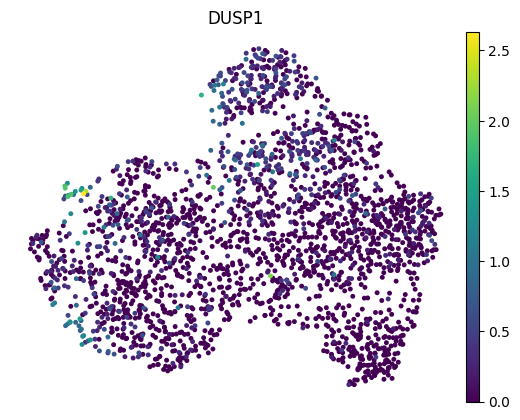

In [22]:
sc.pl.umap(adata, color = ["DUSP1"], frameon = False) # bin and color

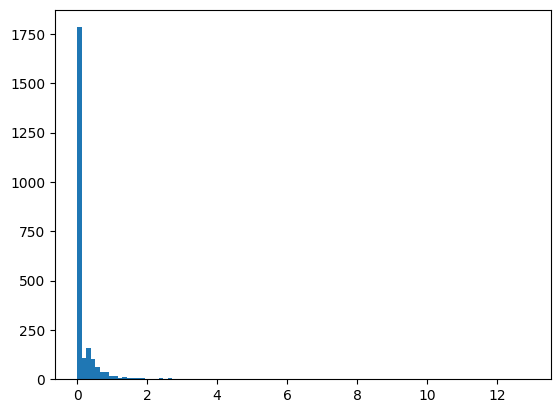

In [23]:
plt.hist(adata[:, 'DUSP1'].layers['counts'], bins = 100) # throw out zero and log scale
# log log scale
plt.show()

In [24]:
adata.layers['counts'].sum(axis = 1)

array([10000.   , 10000.   , 10000.   , ..., 10000.001, 10000.   ,
       10000.   ], dtype=float32)

In [25]:
cell_subset = adata
sum_adata = []
for tp in cell_subset.obs.Timepoint.unique():
    samp_cell_subset = cell_subset[cell_subset.obs['Timepoint'] == tp]
    
    samp_cell_subset.X = samp_cell_subset.layers['counts'] #make sure to use raw data
    
    
    
    indices = list(samp_cell_subset.obs_names)
    random.shuffle(indices)
    indices = np.array_split(np.array(indices), 1) #change number here for number of replicates deisred
    
    for i, pseudo_rep in enumerate(indices):
    
        singles_adata = sc.AnnData(X = np.array([samp_cell_subset[indices[i]].X.sum(axis = 0)]),
                               var = samp_cell_subset[indices[i]].var[[]])

        singles_adata.obs_names = [tp + '_' + str(i)]
        singles_adata.obs['Timepoint'] = samp_cell_subset.obs['Timepoint'].iloc[0]
        singles_adata.obs['replicate'] = i

        sum_adata.append(singles_adata)




sum_adata = sc.concat(sum_adata)

In [26]:
sum_adata[:, 'DUSP1'].obs

,Timepoint,replicate
00_0,00,0
01_0,01,0
02_0,02,0
04_0,04,0
08_0,08,0
18_0,18,0


In [27]:
diff_array = np.zeros([sum_adata.shape[0]-1, sum_adata.shape[1]])
for i, tp in enumerate(sum_adata.obs.Timepoint.unique()):
    try:
        print("_______")
        print(tp)
        print(sum_adata.obs.Timepoint.unique()[i+1])
        tp1 = sum_adata[sum_adata.obs.Timepoint == tp]
        tp2 = sum_adata[sum_adata.obs.Timepoint == sum_adata.obs.Timepoint.unique()[i+1]]
        diff_array[i] = tp1.X - tp2.X
    except IndexError:
        pass # THIS IS BAD BUT SO FUNNY


diff_array

_______
00
01
_______
01
02
_______
02
04
_______
04
08
_______
08
18
_______
18


array([[ 34.21646881, -36.35707092,   6.48643875, ...,  -0.59022886,
         -2.01352096,  -6.0494895 ],
       [-19.48142242,  17.49569702,  -3.81526184, ...,  -0.18599373,
         -2.19180846,  -8.90743446],
       [ -4.39511871,   5.03431702,  -3.07852554, ...,  -5.27276325,
         -4.67512083, -23.88175201],
       [  1.50195312,  22.16879272,  -6.74607086, ...,  -9.93911362,
         -8.30800915,  30.11750031],
       [ 18.36419678, -17.04463196,  19.98218918, ...,   2.128438  ,
          3.44808292,   6.61285496]])

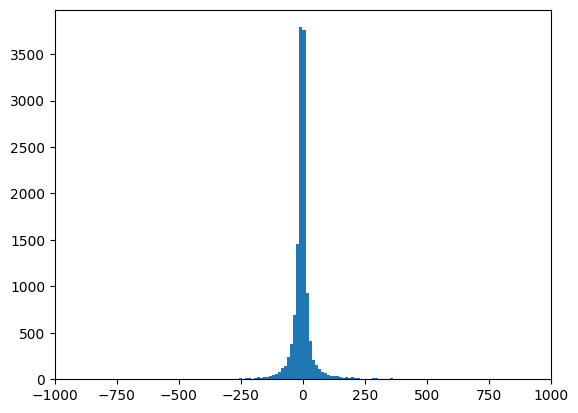

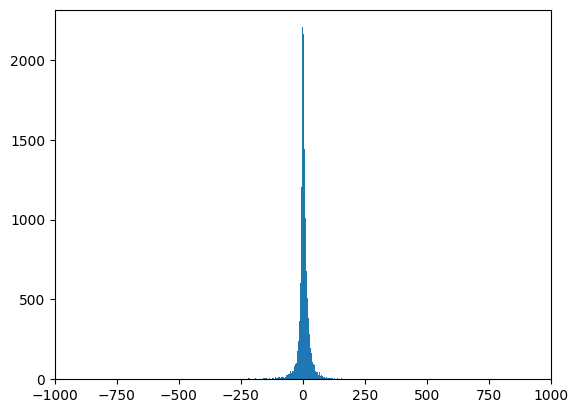

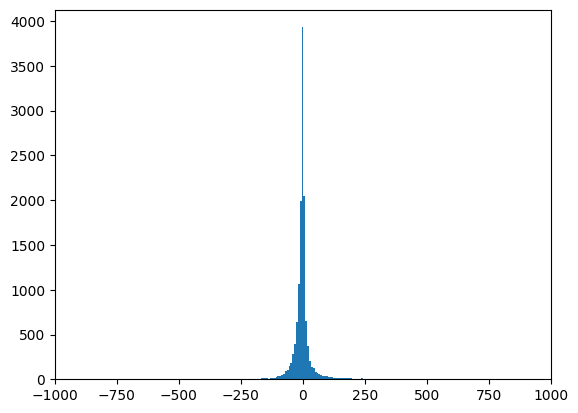

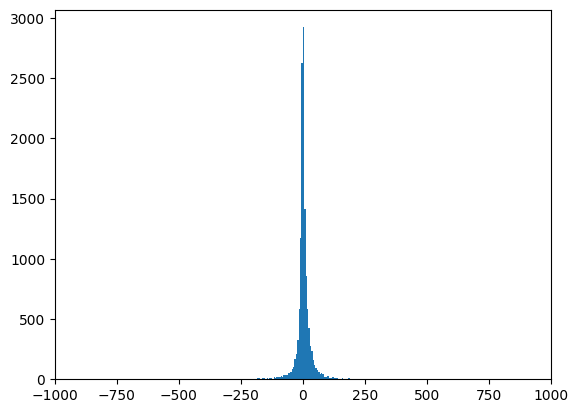

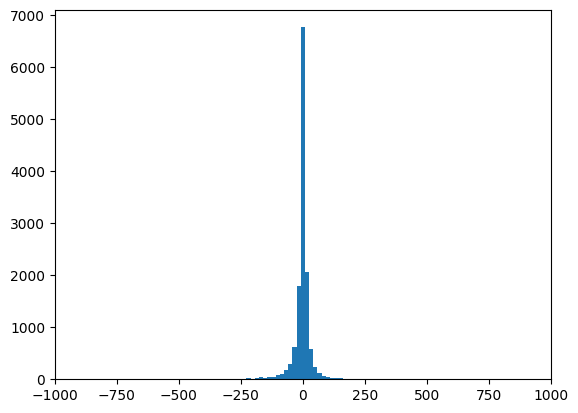

In [28]:
for row in diff_array:
    plt.hist(row, bins=1000)
    plt.xlim(xmin=-1000, xmax=1000)
    plt.show()


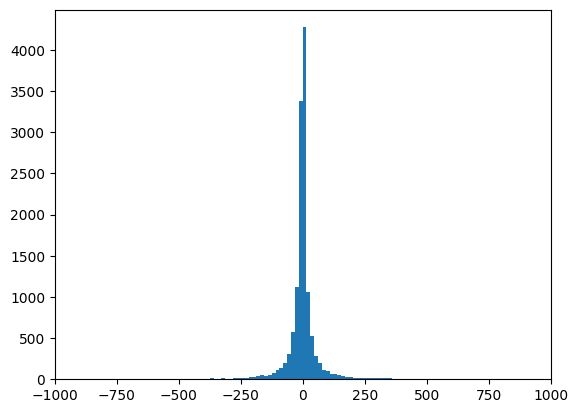

In [29]:
diff_array.sum(axis = 0)
plt.hist(diff_array.sum(axis = 0), bins=1000)
plt.xlim(xmin=-1000, xmax=1000)
plt.show()

In [37]:
binned = np.zeros_like(diff_array)
binned = np.where(diff_array > 0, binned, 1)
binned

array([[0., 1., 0., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [0., 0., 1., ..., 1., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [49]:
encoded = {sum_adata.var_names[i]: str(binned.T[i]) for i in range(binned.T.shape[0])}

In [55]:

bins = list(set(encoded.values()))
len(bins)


32

In [73]:

dicGeneGroups = {}
for i in range(len(bins)):
    listy = []
    for key in encoded:
        if encoded[key] == bins[i]:
            listy.append(key)
    dicGeneGroups[bins[i]] = listy



In [74]:
import csv

# Assuming 'dicGeneGroups' is your dictionary
with open('dicGeneGroups.csv', 'w') as f:
    writer = csv.writer(f)
    for key, value in dicGeneGroups.items():
        a = str(value)
        a = a.replace('[', '')
        a = a.replace(']', '')
        a = a.replace("'", '')
        writer.writerow([key, a])

In [86]:
for i in range(len(bins)):
    print(bins[i])
    print('DUSP1' in dicGeneGroups[bins[i]])



[0. 1. 1. 0. 1.]
False
[1. 0. 0. 1. 0.]
False
[0. 1. 1. 0. 0.]
False
[1. 1. 0. 0. 0.]
False
[0. 0. 1. 1. 0.]
False
[1. 0. 1. 0. 1.]
False
[0. 1. 0. 0. 0.]
False
[1. 1. 1. 0. 1.]
False
[0. 1. 0. 0. 1.]
False
[0. 0. 0. 0. 1.]
False
[1. 1. 0. 1. 1.]
False
[1. 0. 1. 0. 0.]
False
[0. 0. 0. 0. 0.]
False
[0. 0. 0. 1. 0.]
False
[1. 0. 0. 0. 0.]
False
[0. 0. 1. 1. 1.]
False
[1. 0. 0. 1. 1.]
False
[0. 1. 1. 1. 0.]
False
[1. 1. 1. 1. 0.]
False
[0. 1. 0. 1. 1.]
False
[1. 1. 1. 1. 1.]
True
[0. 1. 0. 1. 0.]
False
[0. 0. 1. 0. 0.]
False
[0. 1. 1. 1. 1.]
False
[1. 0. 1. 1. 1.]
False
[0. 0. 0. 1. 1.]
False
[1. 1. 0. 1. 0.]
False
[1. 1. 1. 0. 0.]
False
[0. 0. 1. 0. 1.]
False
[1. 0. 1. 1. 0.]
False
[1. 0. 0. 0. 1.]
False
[1. 1. 0. 0. 1.]
False
